In [39]:
#deal with tensors
import torch   

#handling text data
from torchtext import data

#Ignore printing warnings
import warnings 
warnings.filterwarnings('ignore')

from tqdm import tqdm

In [40]:
#Reproducing same results
SEED = 2019

#Torch
torch.manual_seed(SEED)

#Cuda algorithms
torch.backends.cudnn.deterministic = True  

In [41]:
TEXT = data.Field(tokenize='spacy',batch_first=True,include_lengths=True, lower=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)
fields = [(None, None), ('label', LABEL),(None, None), ('text',TEXT)]

Loading ≈1.5 million tweets. Click  [here](http://thinknook.com/wp-content/uploads/2012/09/Sentiment-Analysis-Dataset.zip)  to download the dataset.

In [42]:
#loading custom dataset
training_data=data.TabularDataset(path='Sentiment Analysis Dataset.csv', format='csv', fields=fields, skip_header=True)

In [43]:
print(vars(training_data.examples[0]))
print(vars(training_data.examples[1]))
print(vars(training_data.examples[-1]))
print(vars(training_data.examples[-2]))

{'label': '0', 'text': ['                     ', 'is', 'so', 'sad', 'for', 'my', 'apl', 'friend', '.............']}
{'label': '0', 'text': ['                   ', 'i', 'missed', 'the', 'new', 'moon', 'trailer', '...']}
{'label': '0', 'text': ['zzzzzzzzzzzzzzzzzzz', ',', 'i', 'wish']}
{'label': '0', 'text': ['zzzzzzzzzzzzz', 'meh', ',', 'what', 'am', 'i', 'doing', 'up', 'again', '?']}


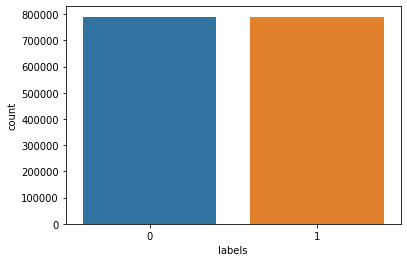

In [44]:
import seaborn as sns
from pandas import DataFrame

df = DataFrame ([vars(i)['label'] for i in training_data.examples],columns=['labels'])
ax = sns.countplot(x="labels", data=df)

In [45]:
import random
train_data, valid_data = training_data.split(split_ratio=0.7, random_state=random.seed(SEED))

In [46]:
#initialize glove embeddings
TEXT.build_vocab(train_data,min_freq=3,vectors = "glove.6B.100d")  
LABEL.build_vocab(train_data)

#No. of unique tokens in text
print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))  

#Word dictionary
#print(TEXT.vocab.stoi)   

Size of TEXT vocabulary: 109445
Size of LABEL vocabulary: 2
[('i', 694321), ('!', 628174), ('.', 564931), (' ', 407152), ('to', 391916), ('the', 363918), (',', 336969), ('a', 265087), ('my', 219387), ('it', 211618)]


In [47]:
print(LABEL.vocab.stoi)

defaultdict(None, {'1': 0, '0': 1})


In [48]:
#check whether cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

#set batch size
BATCH_SIZE = 1024

#Load an iterator
train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_data, valid_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

In [49]:
import torch.nn as nn

class classifier(nn.Module):
    
    #define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout):
        
        #Constructor
        super().__init__()          
        
        #embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm layer
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        
        #dense layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        #activation function
        self.act = nn.Sigmoid()
        
    def forward(self, text, text_lengths):
        
        #text = [batch size,sent_length]
        embedded = self.dropout(self.embedding(text))
        #embedded = self.embedding(text)
        #embedded = [batch size, sent_len, emb dim]
      
        #packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)
        
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
        
        #concat the final forward and backward hidden state
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        #hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
                
        #hidden = [batch size, hid dim * num directions]
        dense_outputs = self.fc(hidden)

        #Final activation function
        outputs=self.act(dense_outputs)
        
        return outputs
    
    
#define hyperparameters
size_of_vocab = len(TEXT.vocab)
embedding_dim = 100
num_hidden_nodes = 32
num_output_nodes = 1
num_layers = 2
bidirection = True
dropout = 0.2

#instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes,num_output_nodes, num_layers, 
                   bidirectional = True, dropout = dropout)

In [50]:
#architecture
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

#Initialize the pretrained embedding
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

print(pretrained_embeddings.shape)

classifier(
  (embedding): Embedding(109445, 100)
  (lstm): LSTM(100, 32, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (act): Sigmoid()
)
The model has 11,003,957 trainable parameters
torch.Size([109445, 100])


In [51]:
import torch.optim as optim

#define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

#define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(preds)
    
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
#push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [52]:
def train(model, iterator, optimizer, criterion):
    
    #initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    #set the model in training phase
    model.train()  
    
    #for batch in tqdm(iterator,total=len(iterator)):
    for batch in iterator:
        
        #resets the gradients after every batch
        optimizer.zero_grad()   
        
        #retrieve text and no. of words
        text, text_lengths = batch.text   
        
        #convert to 1D tensor
        predictions = model(text, text_lengths).squeeze()  
        
        #compute the loss
        loss = criterion(predictions, batch.label)        
        
        #compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label)   
        
        #backpropage the loss and compute the gradients
        loss.backward()       
        
        #update the weights
        optimizer.step()      
        
        #loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [53]:
def evaluate(model, iterator, criterion):
    
    #initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    #deactivating dropout layers
    model.eval()
    
    #deactivates autograd
    with torch.no_grad():
    
        #for batch in tqdm(iterator,total=len(iterator)):
        for batch in iterator:
        
            #retrieve text and no. of words
            text, text_lengths = batch.text
            
            #convert to 1d tensor
            predictions = model(text, text_lengths).squeeze()
            
            #compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            
            #keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [54]:
N_EPOCHS = 10
best_valid_loss = float('inf')

train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

for epoch in range(N_EPOCHS):
     
    #train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    #evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    

	Train Loss: 0.615 | Train Acc: 74.71%
	 Val. Loss: 0.593 |  Val. Acc: 79.96%
	Train Loss: 0.589 | Train Acc: 81.18%
	 Val. Loss: 0.586 |  Val. Acc: 81.26%
	Train Loss: 0.580 | Train Acc: 83.16%
	 Val. Loss: 0.583 |  Val. Acc: 82.81%
	Train Loss: 0.574 | Train Acc: 84.36%
	 Val. Loss: 0.582 |  Val. Acc: 82.54%
	Train Loss: 0.570 | Train Acc: 85.24%
	 Val. Loss: 0.581 |  Val. Acc: 83.19%
	Train Loss: 0.568 | Train Acc: 85.80%
	 Val. Loss: 0.581 |  Val. Acc: 83.46%
	Train Loss: 0.565 | Train Acc: 86.34%
	 Val. Loss: 0.580 |  Val. Acc: 83.40%
	Train Loss: 0.564 | Train Acc: 86.74%
	 Val. Loss: 0.580 |  Val. Acc: 83.35%
	Train Loss: 0.562 | Train Acc: 87.15%
	 Val. Loss: 0.579 |  Val. Acc: 83.50%
	Train Loss: 0.560 | Train Acc: 87.45%
	 Val. Loss: 0.580 |  Val. Acc: 83.88%


Plotting change of accuracy and loss per epoch for both training and validation set

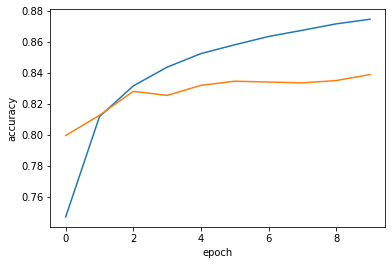

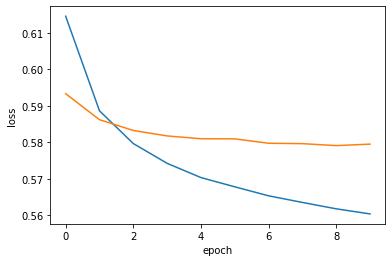

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

epoch = np.array(range(N_EPOCHS))
ta = np.array(train_accs)
va = np.array(valid_accs)
d = {'epoch': epoch, 'accuracy': ta}
sns.lineplot(x='epoch', y='accuracy', data=pd.DataFrame(d))
d = {'epoch': epoch, 'accuracy': va}
sns.lineplot(x='epoch', y='accuracy', data=pd.DataFrame(d))
plt.show()


epoch = np.array(range(N_EPOCHS))
tl = np.array(train_losses)
vl = np.array(valid_losses)
d = {'epoch': epoch, 'loss': tl}
sns.lineplot(x='epoch', y='loss', data=pd.DataFrame(d))
d = {'epoch': epoch, 'loss': vl}
sns.lineplot(x='epoch', y='loss', data=pd.DataFrame(d))
plt.show()

In [56]:
#load weights
path='saved_weights.pt'
model.load_state_dict(torch.load(path));
model.eval();

#inference 
import spacy
nlp = spacy.load('en')

def predict(model, sentence):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]  #tokenize the sentence 
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]          #convert to integer sequence
    length = [len(indexed)]                                    #compute no. of words
    tensor = torch.LongTensor(indexed).to(device)              #convert to tensor
    tensor = tensor.unsqueeze(1).T                             #reshape in form of batch,no. of words
    length_tensor = torch.LongTensor(length)                   #convert to tensor
    prediction = model(tensor, length_tensor)                  #prediction 
    return 1-prediction.item()   

In [61]:
#make predictions
predict(model, "feeling lonely")

2.384185791015625e-07

In [64]:
#insincere question
predict(model, "I love everybody.")

0.9999998952654323